<a href="https://colab.research.google.com/github/nancyerika04/complaint-citizen-analysis/blob/main/complaint_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 I - IMPORT ET PREPARATION

In [ ]:
import pandas as pd

# Charger dataset
df = pd.read_csv("/content/drive/MyDrive/Datas/311_Service_Requests_from_2010_to_Present.csv")

/tmp/ipython-input-1072633955.py:4: DtypeWarning: Columns (48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Datas/311_Service_Requests_from_2010_to_Present.csv")


In [ ]:
# Afficher aperçu
print(df.shape)
print(df.columns)

(364558, 53)
Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Park Facility Name', 'Park Borough',
       'School Name', 'School Number', 'School Region', 'School Code',
       'School Phone Number', 'School Address', 'School City', 'School State',
       'School Zip', 'School Not Found', 'School or Citywide Complaint',
       'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location',
       'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp',
       'Bridge Highway Segment', 'Garage Lot N

In [ ]:
# Supprimer lignes vides dans les colonnes utiles
df = df.dropna(subset=["Complaint Type", "Descriptor"])

In [ ]:
#prendre un échantillon pour tester plus vite
df = df.sample(10000, random_state=42)

In [ ]:
# Fusionner Complaint Type + Descriptor
df["text"] = df["Complaint Type"].astype(str) + " " + df["Descriptor"].astype(str)

II - CLEANING

In [ ]:
import re
import nltk
import spacy

# Télécharger stopwords NLTK et charger spaCy
nltk.download("stopwords")
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text):
    # Minuscule
    text = text.lower()
    # Supprimer caractères spéciaux et chiffres
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenisation + lemmatisation avec spaCy
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(tokens)

In [ ]:
# Appliquer nettoyage
df["text_clean"] = df["text"].apply(preprocess_text)

In [ ]:
for i, row in df[["text", "text_clean"]].head(10).iterrows():
    print(f"Plainte brute : {row['text']}")
    print(f"Texte nettoyé : {row['text_clean']}")
    print("-" * 50)

Plainte brute : Noise - Street/Sidewalk Loud Music/Party
Texte nettoyé : noise streetsidewalk loud musicparty
--------------------------------------------------
Plainte brute : Blocked Driveway No Access
Texte nettoyé : block driveway access
--------------------------------------------------
Plainte brute : Blocked Driveway No Access
Texte nettoyé : block driveway access
--------------------------------------------------
Plainte brute : Illegal Parking Blocked Hydrant
Texte nettoyé : illegal parking block hydrant
--------------------------------------------------
Plainte brute : Derelict Vehicle With License Plate
Texte nettoyé : derelict vehicle license plate
--------------------------------------------------
Plainte brute : Illegal Parking Double Parked Blocking Vehicle
Texte nettoyé : illegal parking double park block vehicle
--------------------------------------------------
Plainte brute : Illegal Parking Commercial Overnight Parking
Texte nettoyé : illegal parking commercial over

III - VECTORIZATION

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

max_features = 5000  # limite pour éviter surcharge mémoire

# CountVectorizer (pour LDA)
count_vectorizer = CountVectorizer(max_features=max_features)
X_count = count_vectorizer.fit_transform(df["text_clean"])
print("CountVectorizer shape:", X_count.shape)

CountVectorizer shape: (10000, 79)


In [ ]:
# TF-IDF (pour K-means)
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
X_tfidf = tfidf_vectorizer.fit_transform(df["text_clean"])
print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (10000, 79)


IV-MODEL

1. LDA (Latent Dirichlet Allocation) – pour extraire les thèmes

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Nombre de thèmes
n_topics = 10

lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X_count)

# Récupérer les mots
words = count_vectorizer.get_feature_names_out()

# Afficher les 10 mots les plus importants de chaque thème
for idx, topic in enumerate(lda.components_):
    print(f"Thème {idx+1}:")
    print([words[i] for i in topic.argsort()[-10:]])  # top 10 mots
    print()

Thème 1:
['speeding', 'shelter', 'police', 'graffiti', 'report', 'request', 'partial', 'block', 'driveway', 'access']

Thème 2:
['play', 'disorderly', 'youth', 'advertisement', 'vend', 'unlicensed', 'derelict', 'plate', 'vehicle', 'license']

Thème 3:
['congestiongridlock', 'noise', 'nuisancetruant', 'traffic', 'speeding', 'shelter', 'hydrant', 'parking', 'illegal', 'block']

Thème 4:
['unauthorized', 'layover', 'storage', 'area', 'prohibit', 'vend', 'overnight', 'commercial', 'illegal', 'parking']

Thème 5:
['bangingpounding', 'idle', 'engine', 'commercial', 'animal', 'abuse', 'music', 'cartruck', 'vehicle', 'noise']

Thème 6:
['stoplight', 'chronic', 'route', 'truck', 'traffic', 'sign', 'post', 'illegal', 'violation', 'parking']

Thème 7:
['traffic', 'speeding', 'shelter', 'television', 'park', 'talk', 'musicparty', 'commercial', 'loud', 'noise']

Thème 8:
['disorderly', 'traffic', 'nuisancetruant', 'vehicle', 'double', 'park', 'sidewalk', 'parking', 'illegal', 'block']

Thème 9:
['n

2. K-means – pour regrouper les plaintes similaires

In [ ]:
from sklearn.cluster import KMeans

# Nombre de clusters (à ajuster)
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# Ajouter les clusters au dataframe
df["cluster"] = clusters

# Afficher quelques exemples par cluster
for c in range(n_clusters):
    print(f"\nCluster {c}:")
    complaints = df[df["cluster"] == c]["text"].head(5).tolist()
    for complaint in complaints:
        print(complaint)



Cluster 0:
Blocked Driveway No Access
Blocked Driveway No Access
Blocked Driveway No Access
Blocked Driveway No Access
Blocked Driveway No Access

Cluster 1:
Illegal Parking Blocked Hydrant
Illegal Parking Double Parked Blocking Vehicle
Illegal Parking Double Parked Blocking Traffic
Illegal Parking Blocked Sidewalk
Illegal Parking Blocked Sidewalk

Cluster 2:
Noise - Vehicle Car/Truck Horn
Noise - Commercial Loud Music/Party
Noise - Vehicle Car/Truck Music
Noise - House of Worship Loud Music/Party
Noise - Vehicle Car/Truck Music

Cluster 3:
Noise - Street/Sidewalk Loud Music/Party
Noise - Street/Sidewalk Loud Talking
Noise - Street/Sidewalk Loud Talking
Noise - Street/Sidewalk Loud Music/Party
Noise - Street/Sidewalk Loud Talking

Cluster 4:
Derelict Vehicle With License Plate
Illegal Parking Commercial Overnight Parking
Derelict Vehicle With License Plate
Derelict Vehicle With License Plate
Derelict Vehicle With License Plate


LDA montre que les thèmes les plus fréquents concernent : le bruit (music/party), le stationnement illégal (blocked driveway, hydrant), et les véhicules abandonnés.

K-means regroupe bien les plaintes par type : un cluster pour le bruit, un pour le parking illégal, un pour les véhicules abandonnés, etc.


CONCLUSION
Cette analyse des plaintes permet d’identifier les problèmes majeurs rencontrés par les citoyens (bruit, stationnement, véhicules abandonnés). Ces résultats peuvent aider la municipalité à prioriser ses actions (par exemple : plus de contrôle du stationnement, campagnes de sensibilisation sur le bruit).

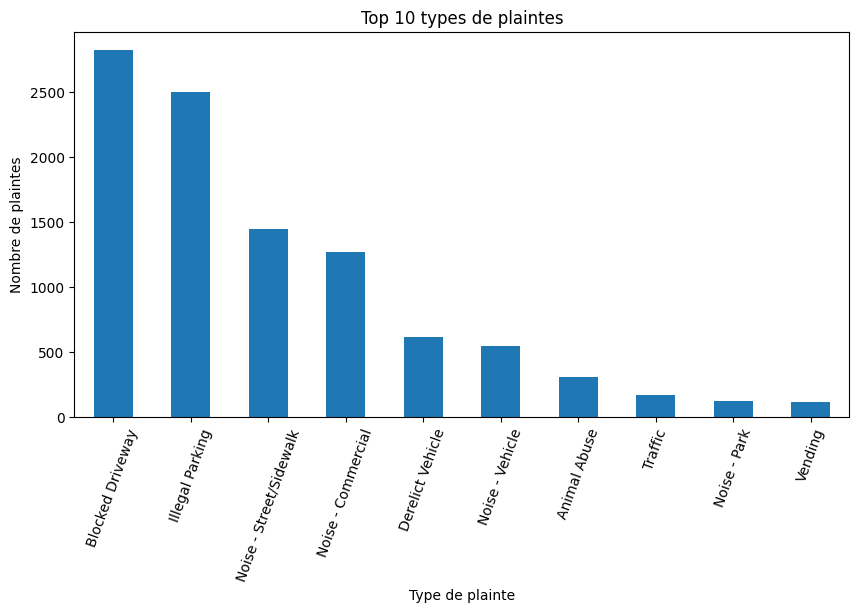

In [ ]:
import matplotlib.pyplot as plt

df["Complaint Type"].value_counts().head(10).plot(kind="bar", figsize=(10,5))
plt.title("Top 10 types de plaintes")
plt.ylabel("Nombre de plaintes")
plt.xlabel("Type de plainte")
plt.xticks(rotation=70)
plt.show()


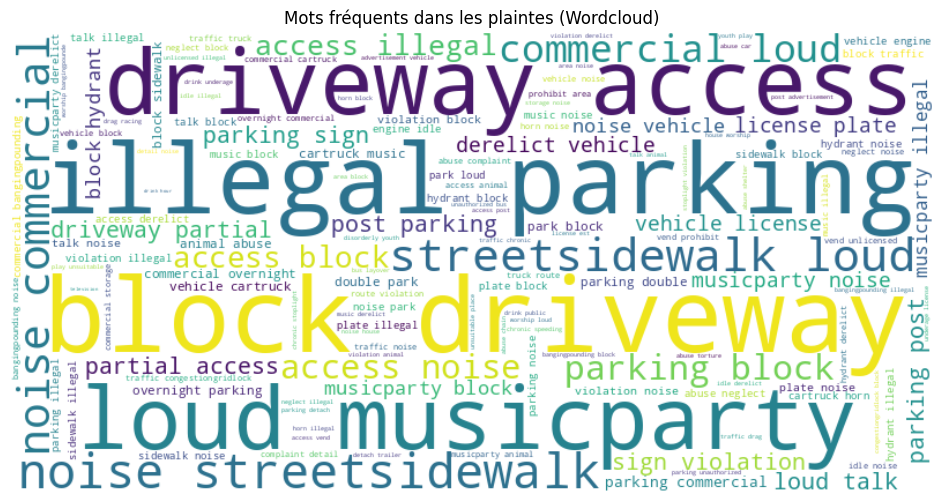

In [ ]:
from wordcloud import WordCloud

text_data = " ".join(df["text_clean"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Mots fréquents dans les plaintes (Wordcloud)")
plt.show()
